In [1]:
import torch
from torch import nn,optim
import functools
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.utils as vutils

In [2]:
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from skimage.transform import resize

In [3]:
from tensorboardX import SummaryWriter
writer=SummaryWriter('/user1/faculty/cvpr/ujjwal/dhritimaan/GANs/datasets/log_cycle_gan_foggy/')

In [4]:
class SequenceFolder(data.Dataset):
    def __init__(self, trainA,trainB):
        self.trainA=trainA
        self.trainB=trainB

    def __len__(self):
        return 1556
    def __getitem__(self, index):
        index_a=index%len(self.trainA)
        index_b=index%len(self.trainB)
        imgA=plt.imread(self.trainA[index_a])
        imgB=plt.imread(self.trainB[index_b])
        imgA=resize(imgA,(256,256,3))
        imgB=resize(imgB,(256,256,3))
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        #index=index%
        dict_img={'A':imgA,'B':imgB}
        return dict_img

In [5]:
#plt.imread(foggy_paths[0]).shape
import os

In [6]:
file1 = open("/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich/lists_file_names/RGB_medium_filenames.txt",
             "r")
x=file1.read()
foggy_paths=[os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/foggy_zurich/Foggy_Zurich',t) for t in x.splitlines()]

In [7]:
import os
city=os.listdir('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train')

In [8]:
img_paths=[]
for i in range(10):
    city_path=os.path.join('/user1/faculty/cvpr/ujjwal/kaiser/dataset/cityscape/leftImg8bit/train',city[i])
    img_names=os.listdir(city_path)
    k=[os.path.join(city_path,s) for s in img_names]
    for j in range(len(k)):
        img_paths.append(k[j])

In [9]:
#foggy_paths

In [10]:
train=SequenceFolder(foggy_paths,img_paths)#lista,listb)

In [11]:
dataloader=torch.utils.data.DataLoader(train,batch_size=4,shuffle=True)

In [12]:
import matplotlib.pyplot as plt
for a,b in enumerate(dataloader):
    a
    break

In [13]:
b['A'].shape

torch.Size([4, 256, 256, 3])

In [14]:
b['B'].permute(0,3,1,2).shape

torch.Size([4, 3, 256, 256])

In [15]:
#torch.cat((b['A'].permute(0,3,1,2),b['B'].permute(0,3,1,2)),1).shape

In [16]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [17]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [18]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [19]:
cuda=torch.device('cuda:1')
gen_encoder_a=ResnetGenerator(3,6).to(cuda)
gen_encoder_b=ResnetGenerator(3,6).to(cuda)
gen_decoder_acbs=ResnetGenerator(6,3).to(cuda)
gen_decoder_asbc=ResnetGenerator(6,3).to(cuda)

In [20]:
#disc_style=NLayerDiscriminator(3).to(cuda)
disc_acbs=NLayerDiscriminator(3).to(cuda)
disc_asbc=NLayerDiscriminator(3).to(cuda)

In [21]:
from itertools import chain

In [22]:
gen_optim=optim.Adam(chain(gen_encoder_a.parameters(),gen_encoder_b.parameters(),
                     gen_decoder_acbs.parameters(),gen_decoder_asbc.parameters()),
                     lr=0.0002,betas=(0.5,0.999))
dis_optim=optim.Adam(chain(disc_acbs.parameters(),disc_asbc.parameters()),lr=0.0002,betas=(0.5,0.999))

In [23]:
#loss_ce=nn.NLLLoss()
loss_mse=nn.MSELoss()
#loss_rec=l1loss()+-

In [24]:
def l1loss(x,y):
    return torch.mean(torch.abs(x-y))
def mse(x,y):
    return torch.mean((x-y)**2)

In [25]:
#nn.L1Loss()
#import skimage
#gen_encoder(torch.zeros(1,3,256,256).to(cuda)).shape

In [26]:
from skimage.transform import resize

In [27]:
#genAB(torch.cat((b['A'],b['A']),1).permute(0,3,1,2).float().to(cuda)/255)

In [29]:
num_epochs=100
count=0
for epoch in range(num_epochs):
    for n_batches,real_data in enumerate(dataloader):
        foggy=real_data['A'].permute(0,3,1,2).float().to(cuda)#/255
        normal=real_data['B'].permute(0,3,1,2).float().to(cuda)#/255
        
        
        #realA=torch.cat((realA_,realA_),1)
        #realB=torch.cat((realA_,realB_),1)
        
        
        st_ct_a=gen_encoder_a(foggy)
        st_ct_b=gen_encoder_b(normal)
        content_a=st_ct_a[:,:3,:,:]
        style_a=st_ct_a[:,3:,:,:]
        content_b=st_ct_b[:,:3,:,:]
        style_b=st_ct_b[:,3:,:,:]
        
        rec_b=gen_decoder_acbs(torch.cat((content_a,style_b),1))
        rec_a=gen_decoder_asbc(torch.cat((content_b,style_a),1))
        
        label_rec_b=disc_acbs(rec_b)
        label_real_b=disc_asbc(normal)
        label_rec_a=disc_acbs(rec_a)
        label_real_a=disc_acbs(foggy)
        
        gen_optim.zero_grad()
        #######training generators
        error_disc_asbc=loss_mse(label_rec_b,Variable(torch.ones(foggy.shape[0],1,30,30).to(cuda)))
        error_dis_acbs=loss_mse(label_rec_a,Variable(torch.ones(foggy.shape[0],1,30,30).to(cuda)))
        #rec_errorA=l1loss(rec_foggy,foggy)#loss_rec(recA,realA)
        #rec_errorB=l1loss(recB,realB)#loss_rec(recB,realB)
        #str_loss_b=l1loss(rec_b,normal)
        #str_loss_a=l1loss(rec_a,foggy)
                            
        g_loss=(error_disc_asbc+error_dis_acbs)/2#+10*str_loss_b+10*str_loss_a
        #error_genAB.backward(retain_graph=True)
        #error_genBA.backward()
        #rec_errorA.backward()
        #rec_errorB.backward()
        g_loss.backward()#retain_graph=True)
        
        gen_optim.step()
    
        #########training discrminators
        dis_optim.zero_grad()
        
        st_ct_a=gen_encoder_a(foggy)
        st_ct_b=gen_encoder_b(normal)
        content_a=st_ct_a[:,:3,:,:]
        style_a=st_ct_a[:,3:,:,:]
        content_b=st_ct_b[:,:3,:,:]
        style_b=st_ct_b[:,3:,:,:]
        
        rec_b=gen_decoder_acbs(torch.cat((content_a,style_b),1))
        rec_a=gen_decoder_asbc(torch.cat((content_b,style_a),1))
        
        label_rec_b=disc_acbs(rec_b)
        label_real_b=disc_asbc(normal)
        label_rec_a=disc_acbs(rec_a)
        label_real_a=disc_acbs(foggy)
        
        error__rec_disc_asbc=loss_mse(label_rec_b,Variable(torch.zeros(foggy.shape[0],1,30,30).to(cuda)))
        error__real_disc_asbc=loss_mse(label_real_b,Variable(torch.ones(foggy.shape[0],1,30,30).to(cuda)))
        error__rec_disc_acbs=loss_mse(label_rec_a,Variable(torch.zeros(foggy.shape[0],1,30,30).to(cuda)))
        error__real_disc_acbs=loss_mse(label_real_a,Variable(torch.ones(foggy.shape[0],1,30,30).to(cuda)))
        
        
        disc_loss=(error__rec_disc_asbc+error__real_disc_asbc)/2+(error__rec_disc_acbs+error__real_disc_acbs)/2
        disc_loss.backward()
        #error_discAB_with_fakeB.backward()
        #error_discBA_with_realB.backward()
        #error_discBA_with_realB.backward()
        dis_optim.step()
        
        
        if count%10==0:
            writer.add_image("rec_a_foggy",vutils.make_grid(rec_a,padding=2,normalize=True),count)#foggy
            writer.add_image("rec_b_normal",vutils.make_grid(rec_b,padding=2,normalize=True),count)##city
            writer.add_image("foggy",vutils.make_grid(foggy,padding=2,normalize=True),count)
            writer.add_image("normal",vutils.make_grid(normal,padding=2,normalize=True),count)
        
        
        count=count+1
        print("epoch:{}  disc_loss:{}  gen_loss:{}".format(epoch
                                    ,disc_loss,g_loss))

epoch:0  disc_loss:3.026087760925293  gen_loss:1.4270470142364502
epoch:0  disc_loss:5.153626441955566  gen_loss:1.1695537567138672
epoch:0  disc_loss:1.2635533809661865  gen_loss:1.0081874132156372
epoch:0  disc_loss:0.6909289956092834  gen_loss:0.6932256817817688
epoch:0  disc_loss:0.628352701663971  gen_loss:0.9889733791351318
epoch:0  disc_loss:0.4059033989906311  gen_loss:0.7964658737182617
epoch:0  disc_loss:0.40544503927230835  gen_loss:0.7727655172348022
epoch:0  disc_loss:0.32996222376823425  gen_loss:0.7518688440322876
epoch:0  disc_loss:0.3108207881450653  gen_loss:0.7288954257965088
epoch:0  disc_loss:0.2934974730014801  gen_loss:0.7669774293899536
epoch:0  disc_loss:0.3473796844482422  gen_loss:0.8165246248245239
epoch:0  disc_loss:0.2683890163898468  gen_loss:0.8657529354095459
epoch:0  disc_loss:0.32292836904525757  gen_loss:0.9103922843933105
epoch:0  disc_loss:0.36314141750335693  gen_loss:0.9424911141395569
epoch:0  disc_loss:0.2968639135360718  gen_loss:0.90884327888

epoch:0  disc_loss:0.3560982644557953  gen_loss:0.4717836380004883
epoch:0  disc_loss:0.36739328503608704  gen_loss:0.45535513758659363
epoch:0  disc_loss:0.3584411144256592  gen_loss:0.48714566230773926
epoch:0  disc_loss:0.36266830563545227  gen_loss:0.4406132698059082
epoch:0  disc_loss:0.37558940052986145  gen_loss:0.4550205171108246
epoch:0  disc_loss:0.37048688530921936  gen_loss:0.4518224596977234
epoch:0  disc_loss:0.3529089391231537  gen_loss:0.4687303900718689
epoch:0  disc_loss:0.34949102997779846  gen_loss:0.43625688552856445
epoch:0  disc_loss:0.35476255416870117  gen_loss:0.4610285758972168
epoch:0  disc_loss:0.3536386489868164  gen_loss:0.45495909452438354
epoch:0  disc_loss:0.3546753525733948  gen_loss:0.45968353748321533
epoch:0  disc_loss:0.34889042377471924  gen_loss:0.452030211687088
epoch:0  disc_loss:0.3505181670188904  gen_loss:0.4762820899486542
epoch:0  disc_loss:0.3485383987426758  gen_loss:0.4397233724594116
epoch:0  disc_loss:0.3511744737625122  gen_loss:0.4

epoch:0  disc_loss:0.3414188325405121  gen_loss:0.4469265043735504
epoch:0  disc_loss:0.34654998779296875  gen_loss:0.50309157371521
epoch:0  disc_loss:0.3479786515235901  gen_loss:0.4407408833503723
epoch:0  disc_loss:0.34709274768829346  gen_loss:0.4651080369949341
epoch:0  disc_loss:0.34275883436203003  gen_loss:0.46392059326171875
epoch:0  disc_loss:0.3421269655227661  gen_loss:0.45056211948394775
epoch:0  disc_loss:0.35027632117271423  gen_loss:0.43324780464172363
epoch:0  disc_loss:0.35493141412734985  gen_loss:0.465129017829895
epoch:0  disc_loss:0.34843191504478455  gen_loss:0.4649087190628052
epoch:0  disc_loss:0.3527892529964447  gen_loss:0.4296860098838806
epoch:0  disc_loss:0.35906434059143066  gen_loss:0.48926764726638794
epoch:0  disc_loss:0.3542441427707672  gen_loss:0.45248907804489136
epoch:0  disc_loss:0.35154038667678833  gen_loss:0.48357290029525757
epoch:0  disc_loss:0.3498176634311676  gen_loss:0.44371122121810913
epoch:0  disc_loss:0.3474983274936676  gen_loss:0.

epoch:0  disc_loss:0.366954505443573  gen_loss:0.4835280478000641
epoch:0  disc_loss:0.3519788980484009  gen_loss:0.4828576445579529
epoch:0  disc_loss:0.34326568245887756  gen_loss:0.44624197483062744
epoch:0  disc_loss:0.3471768796443939  gen_loss:0.4703054130077362
epoch:0  disc_loss:0.34717047214508057  gen_loss:0.437297523021698
epoch:0  disc_loss:0.3416914939880371  gen_loss:0.4686591625213623
epoch:0  disc_loss:0.342839777469635  gen_loss:0.46124428510665894
epoch:0  disc_loss:0.3409455418586731  gen_loss:0.4436851739883423
epoch:0  disc_loss:0.3401324152946472  gen_loss:0.4425542950630188
epoch:0  disc_loss:0.3393818140029907  gen_loss:0.4525596797466278
epoch:0  disc_loss:0.34151431918144226  gen_loss:0.42384472489356995
epoch:0  disc_loss:0.3408401608467102  gen_loss:0.4566724896430969
epoch:0  disc_loss:0.3424609303474426  gen_loss:0.4676603674888611
epoch:0  disc_loss:0.33885180950164795  gen_loss:0.45176565647125244
epoch:0  disc_loss:0.3391873836517334  gen_loss:0.4649757

epoch:1  disc_loss:0.35580211877822876  gen_loss:0.4406192898750305
epoch:1  disc_loss:0.3490978181362152  gen_loss:0.47053295373916626
epoch:1  disc_loss:0.3460176885128021  gen_loss:0.454908549785614
epoch:1  disc_loss:0.3429127037525177  gen_loss:0.43487420678138733
epoch:1  disc_loss:0.35672688484191895  gen_loss:0.44125282764434814
epoch:1  disc_loss:0.36104893684387207  gen_loss:0.48035597801208496
epoch:1  disc_loss:0.3496474027633667  gen_loss:0.43291449546813965
epoch:1  disc_loss:0.3396885395050049  gen_loss:0.4730381667613983
epoch:1  disc_loss:0.3410750925540924  gen_loss:0.4539933502674103
epoch:1  disc_loss:0.3407962918281555  gen_loss:0.43668174743652344
epoch:1  disc_loss:0.34825438261032104  gen_loss:0.48131394386291504
epoch:1  disc_loss:0.3508286476135254  gen_loss:0.422733336687088
epoch:1  disc_loss:0.3481096625328064  gen_loss:0.47708141803741455
epoch:1  disc_loss:0.34545519948005676  gen_loss:0.4566856622695923
epoch:1  disc_loss:0.3494778275489807  gen_loss:0.4

epoch:1  disc_loss:0.34897905588150024  gen_loss:0.4402448534965515
epoch:1  disc_loss:0.3550053834915161  gen_loss:0.47503143548965454
epoch:1  disc_loss:0.35917797684669495  gen_loss:0.430706262588501
epoch:1  disc_loss:0.3513828217983246  gen_loss:0.46392613649368286
epoch:1  disc_loss:0.3493543863296509  gen_loss:0.4535331130027771
epoch:1  disc_loss:0.35295525193214417  gen_loss:0.4838699698448181
epoch:1  disc_loss:0.3596964478492737  gen_loss:0.44704896211624146
epoch:1  disc_loss:0.3705776333808899  gen_loss:0.4918922483921051
epoch:1  disc_loss:0.3749876022338867  gen_loss:0.48714518547058105
epoch:1  disc_loss:0.3794216513633728  gen_loss:0.48721855878829956
epoch:1  disc_loss:0.37828636169433594  gen_loss:0.4839133322238922
epoch:1  disc_loss:0.366794228553772  gen_loss:0.49250760674476624
epoch:1  disc_loss:0.35042595863342285  gen_loss:0.4369457960128784
epoch:1  disc_loss:0.34564146399497986  gen_loss:0.4626663327217102
epoch:1  disc_loss:0.34693101048469543  gen_loss:0.4

epoch:1  disc_loss:0.3398135006427765  gen_loss:0.45198631286621094
epoch:1  disc_loss:0.338466614484787  gen_loss:0.45174890756607056
epoch:1  disc_loss:0.3503515422344208  gen_loss:0.4379896819591522
epoch:1  disc_loss:0.3494456112384796  gen_loss:0.44856059551239014
epoch:1  disc_loss:0.3407977223396301  gen_loss:0.45906132459640503
epoch:1  disc_loss:0.3410734534263611  gen_loss:0.4700144827365875
epoch:1  disc_loss:0.34446272253990173  gen_loss:0.42991822957992554
epoch:1  disc_loss:0.34703823924064636  gen_loss:0.45476722717285156
epoch:1  disc_loss:0.3514336347579956  gen_loss:0.4588077664375305
epoch:1  disc_loss:0.3569486141204834  gen_loss:0.44551223516464233
epoch:1  disc_loss:0.3737398087978363  gen_loss:0.4897310733795166
epoch:1  disc_loss:0.39670053124427795  gen_loss:0.4361416697502136
epoch:1  disc_loss:0.38722658157348633  gen_loss:0.507533073425293
epoch:1  disc_loss:0.39048153162002563  gen_loss:0.4541911482810974
epoch:1  disc_loss:0.39064276218414307  gen_loss:0.5

epoch:2  disc_loss:0.3643850088119507  gen_loss:0.46902745962142944
epoch:2  disc_loss:0.3657500147819519  gen_loss:0.4598881006240845
epoch:2  disc_loss:0.3589382767677307  gen_loss:0.47061604261398315
epoch:2  disc_loss:0.35770145058631897  gen_loss:0.4660540223121643
epoch:2  disc_loss:0.36238378286361694  gen_loss:0.46665987372398376
epoch:2  disc_loss:0.35749372839927673  gen_loss:0.4900086522102356
epoch:2  disc_loss:0.3487187922000885  gen_loss:0.42246705293655396
epoch:2  disc_loss:0.3442121148109436  gen_loss:0.4978658854961395
epoch:2  disc_loss:0.34132543206214905  gen_loss:0.4111461639404297
epoch:2  disc_loss:0.3393615186214447  gen_loss:0.4464378356933594
epoch:2  disc_loss:0.3425098955631256  gen_loss:0.45525145530700684
epoch:2  disc_loss:0.3406562805175781  gen_loss:0.44393062591552734
epoch:2  disc_loss:0.3437041640281677  gen_loss:0.4484366178512573
epoch:2  disc_loss:0.3499647080898285  gen_loss:0.44978106021881104
epoch:2  disc_loss:0.35095271468162537  gen_loss:0.

epoch:2  disc_loss:0.3377959728240967  gen_loss:0.4288159906864166
epoch:2  disc_loss:0.3465383052825928  gen_loss:0.46728911995887756
epoch:2  disc_loss:0.3478468358516693  gen_loss:0.4694867730140686
epoch:2  disc_loss:0.346561461687088  gen_loss:0.40920722484588623
epoch:2  disc_loss:0.34552067518234253  gen_loss:0.4864739775657654
epoch:2  disc_loss:0.3467496931552887  gen_loss:0.4488298296928406
epoch:2  disc_loss:0.34693336486816406  gen_loss:0.46683502197265625
epoch:2  disc_loss:0.3466181755065918  gen_loss:0.4457920789718628
epoch:2  disc_loss:0.347759485244751  gen_loss:0.44655120372772217
epoch:2  disc_loss:0.353696346282959  gen_loss:0.4584066867828369
epoch:2  disc_loss:0.36061105132102966  gen_loss:0.46478065848350525
epoch:2  disc_loss:0.35274869203567505  gen_loss:0.440386027097702
epoch:2  disc_loss:0.3456524908542633  gen_loss:0.4564198851585388
epoch:2  disc_loss:0.3415251672267914  gen_loss:0.45579051971435547
epoch:2  disc_loss:0.3452852964401245  gen_loss:0.430034

epoch:2  disc_loss:0.3410031497478485  gen_loss:0.43191754817962646
epoch:2  disc_loss:0.34161895513534546  gen_loss:0.44136473536491394
epoch:2  disc_loss:0.3404083549976349  gen_loss:0.4714144170284271
epoch:2  disc_loss:0.33697593212127686  gen_loss:0.4538159966468811
epoch:2  disc_loss:0.33828479051589966  gen_loss:0.43063682317733765
epoch:2  disc_loss:0.33943817019462585  gen_loss:0.4759625792503357
epoch:2  disc_loss:0.34214767813682556  gen_loss:0.4502642750740051
epoch:2  disc_loss:0.34245193004608154  gen_loss:0.44106653332710266
epoch:2  disc_loss:0.33651307225227356  gen_loss:0.45958060026168823
epoch:2  disc_loss:0.34101447463035583  gen_loss:0.45922887325286865
epoch:2  disc_loss:0.34946274757385254  gen_loss:0.44732367992401123
epoch:2  disc_loss:0.3401036560535431  gen_loss:0.4714336395263672
epoch:2  disc_loss:0.33625227212905884  gen_loss:0.4421239495277405
epoch:2  disc_loss:0.3371579051017761  gen_loss:0.4515131711959839
epoch:2  disc_loss:0.33716440200805664  gen_l

epoch:3  disc_loss:0.3809797763824463  gen_loss:0.35361871123313904
epoch:3  disc_loss:0.41400542855262756  gen_loss:0.6358659267425537
epoch:3  disc_loss:0.43486613035202026  gen_loss:0.43683570623397827
epoch:3  disc_loss:0.4171748757362366  gen_loss:0.51384437084198
epoch:3  disc_loss:0.40385937690734863  gen_loss:0.6306624412536621
epoch:3  disc_loss:0.3910987675189972  gen_loss:0.31059813499450684
epoch:3  disc_loss:0.37819328904151917  gen_loss:0.6204756498336792
epoch:3  disc_loss:0.3688482940196991  gen_loss:0.4607478976249695
epoch:3  disc_loss:0.36904773116111755  gen_loss:0.3620305061340332
epoch:3  disc_loss:0.36399415135383606  gen_loss:0.5977301597595215
epoch:3  disc_loss:0.357256680727005  gen_loss:0.3863411545753479
epoch:3  disc_loss:0.35180291533470154  gen_loss:0.47799399495124817
epoch:3  disc_loss:0.3637140989303589  gen_loss:0.4588724672794342
epoch:3  disc_loss:0.3714364171028137  gen_loss:0.5074995756149292
epoch:3  disc_loss:0.3558569550514221  gen_loss:0.4020

epoch:3  disc_loss:0.3425629734992981  gen_loss:0.4264942705631256
epoch:3  disc_loss:0.3378298878669739  gen_loss:0.4477957487106323
epoch:3  disc_loss:0.33658310770988464  gen_loss:0.45022594928741455
epoch:3  disc_loss:0.3360484838485718  gen_loss:0.438223659992218
epoch:3  disc_loss:0.3372853696346283  gen_loss:0.45007529854774475
epoch:3  disc_loss:0.33555302023887634  gen_loss:0.4563126862049103
epoch:3  disc_loss:0.3370266258716583  gen_loss:0.4496389329433441
epoch:3  disc_loss:0.3373924195766449  gen_loss:0.4520809054374695
epoch:3  disc_loss:0.3368256092071533  gen_loss:0.4614899158477783
epoch:3  disc_loss:0.33592450618743896  gen_loss:0.449601948261261
epoch:3  disc_loss:0.33814576268196106  gen_loss:0.47673267126083374
epoch:3  disc_loss:0.3396969437599182  gen_loss:0.42675966024398804
epoch:3  disc_loss:0.34252333641052246  gen_loss:0.45846325159072876
epoch:3  disc_loss:0.3406004309654236  gen_loss:0.42603737115859985
epoch:3  disc_loss:0.33769094944000244  gen_loss:0.45

epoch:3  disc_loss:0.33845454454421997  gen_loss:0.4452306628227234
epoch:3  disc_loss:0.33887621760368347  gen_loss:0.44408732652664185
epoch:3  disc_loss:0.33876940608024597  gen_loss:0.4488786458969116
epoch:3  disc_loss:0.3369736671447754  gen_loss:0.4494895339012146
epoch:3  disc_loss:0.338228315114975  gen_loss:0.4423406720161438
epoch:3  disc_loss:0.33831411600112915  gen_loss:0.4478851854801178
epoch:3  disc_loss:0.33589720726013184  gen_loss:0.45144498348236084
epoch:3  disc_loss:0.334747314453125  gen_loss:0.4447300434112549
epoch:3  disc_loss:0.33571499586105347  gen_loss:0.44611161947250366
epoch:3  disc_loss:0.33657005429267883  gen_loss:0.44507715106010437
epoch:3  disc_loss:0.3403923809528351  gen_loss:0.4528334140777588
epoch:3  disc_loss:0.3425331711769104  gen_loss:0.4460965394973755
epoch:3  disc_loss:0.34813910722732544  gen_loss:0.4452074468135834
epoch:3  disc_loss:0.347589910030365  gen_loss:0.462044358253479
epoch:3  disc_loss:0.34037014842033386  gen_loss:0.424

epoch:4  disc_loss:0.3376898765563965  gen_loss:0.4558309018611908
epoch:4  disc_loss:0.33677440881729126  gen_loss:0.4495464563369751
epoch:4  disc_loss:0.3371548652648926  gen_loss:0.43890923261642456
epoch:4  disc_loss:0.3434320092201233  gen_loss:0.4612434506416321
epoch:4  disc_loss:0.3504551947116852  gen_loss:0.45706188678741455
epoch:4  disc_loss:0.34960970282554626  gen_loss:0.4504585862159729
epoch:4  disc_loss:0.3417104482650757  gen_loss:0.43577611446380615
epoch:4  disc_loss:0.3391619324684143  gen_loss:0.46509891748428345
epoch:4  disc_loss:0.3415592312812805  gen_loss:0.4295766353607178
epoch:4  disc_loss:0.3436508774757385  gen_loss:0.4735966920852661
epoch:4  disc_loss:0.3440965414047241  gen_loss:0.434198260307312
epoch:4  disc_loss:0.33939871191978455  gen_loss:0.466874361038208
epoch:4  disc_loss:0.33924275636672974  gen_loss:0.44580262899398804
epoch:4  disc_loss:0.34274718165397644  gen_loss:0.44980621337890625
epoch:4  disc_loss:0.3419061303138733  gen_loss:0.443

epoch:4  disc_loss:0.33893686532974243  gen_loss:0.4504219889640808
epoch:4  disc_loss:0.3362162709236145  gen_loss:0.4310453534126282
epoch:4  disc_loss:0.3367038071155548  gen_loss:0.460997998714447
epoch:4  disc_loss:0.33786922693252563  gen_loss:0.43393129110336304
epoch:4  disc_loss:0.33930641412734985  gen_loss:0.4577362537384033
epoch:4  disc_loss:0.34132206439971924  gen_loss:0.44181740283966064
epoch:4  disc_loss:0.33871352672576904  gen_loss:0.4629487693309784
epoch:4  disc_loss:0.338714599609375  gen_loss:0.4261876940727234
epoch:4  disc_loss:0.3388965427875519  gen_loss:0.4777849316596985
epoch:4  disc_loss:0.3390360176563263  gen_loss:0.4495440721511841
epoch:4  disc_loss:0.34109240770339966  gen_loss:0.45313531160354614
epoch:4  disc_loss:0.34420695900917053  gen_loss:0.46085983514785767
epoch:4  disc_loss:0.3468714654445648  gen_loss:0.45529302954673767
epoch:4  disc_loss:0.34521427750587463  gen_loss:0.4569249749183655
epoch:4  disc_loss:0.34784871339797974  gen_loss:0.

epoch:4  disc_loss:0.33863669633865356  gen_loss:0.4489985704421997
epoch:4  disc_loss:0.34339815378189087  gen_loss:0.4280744791030884
epoch:4  disc_loss:0.3457799553871155  gen_loss:0.4695591330528259
epoch:4  disc_loss:0.3418715298175812  gen_loss:0.4354506731033325
epoch:4  disc_loss:0.34231454133987427  gen_loss:0.4480056166648865
epoch:4  disc_loss:0.3441525101661682  gen_loss:0.4447576403617859
epoch:4  disc_loss:0.3387070894241333  gen_loss:0.44675207138061523
epoch:4  disc_loss:0.3373722434043884  gen_loss:0.44875410199165344
epoch:4  disc_loss:0.33962228894233704  gen_loss:0.43931567668914795
epoch:4  disc_loss:0.33694350719451904  gen_loss:0.4594165086746216
epoch:4  disc_loss:0.33680659532546997  gen_loss:0.41993874311447144
epoch:4  disc_loss:0.33693647384643555  gen_loss:0.48942631483078003
epoch:4  disc_loss:0.33517971634864807  gen_loss:0.42324092984199524
epoch:4  disc_loss:0.3348632752895355  gen_loss:0.4672507047653198
epoch:4  disc_loss:0.33542221784591675  gen_loss

epoch:4  disc_loss:0.3453296720981598  gen_loss:0.5005570650100708
epoch:4  disc_loss:0.3453410565853119  gen_loss:0.420600026845932
epoch:5  disc_loss:0.34712523221969604  gen_loss:0.490276962518692
epoch:5  disc_loss:0.3436295986175537  gen_loss:0.42571812868118286
epoch:5  disc_loss:0.34132713079452515  gen_loss:0.4545808434486389
epoch:5  disc_loss:0.3380831480026245  gen_loss:0.4667391777038574
epoch:5  disc_loss:0.3385652005672455  gen_loss:0.41773927211761475
epoch:5  disc_loss:0.3414126932621002  gen_loss:0.49744153022766113
epoch:5  disc_loss:0.3429209589958191  gen_loss:0.39471128582954407
epoch:5  disc_loss:0.3419402539730072  gen_loss:0.5089650750160217
epoch:5  disc_loss:0.34134894609451294  gen_loss:0.4085049033164978
epoch:5  disc_loss:0.3410404324531555  gen_loss:0.47275981307029724
epoch:5  disc_loss:0.34466177225112915  gen_loss:0.43941599130630493
epoch:5  disc_loss:0.34708070755004883  gen_loss:0.46975189447402954
epoch:5  disc_loss:0.3595520555973053  gen_loss:0.45

epoch:5  disc_loss:0.289213091135025  gen_loss:0.6037147045135498
epoch:5  disc_loss:0.2885620594024658  gen_loss:0.5961137413978577
epoch:5  disc_loss:0.28475916385650635  gen_loss:0.5961309671401978
epoch:5  disc_loss:0.2809915244579315  gen_loss:0.5892465114593506
epoch:5  disc_loss:0.2869054973125458  gen_loss:0.5968911647796631
epoch:5  disc_loss:0.2994634509086609  gen_loss:0.567270040512085
epoch:5  disc_loss:0.31802403926849365  gen_loss:0.6394954323768616
epoch:5  disc_loss:0.32088160514831543  gen_loss:0.5053336024284363
epoch:5  disc_loss:0.32020264863967896  gen_loss:0.6237875819206238
epoch:5  disc_loss:0.3408050835132599  gen_loss:0.43015119433403015
epoch:5  disc_loss:0.38742706179618835  gen_loss:0.6475225687026978
epoch:5  disc_loss:0.3990563452243805  gen_loss:0.5615671873092651
epoch:5  disc_loss:0.40995559096336365  gen_loss:0.37056416273117065
epoch:5  disc_loss:0.3613492250442505  gen_loss:0.5809751749038696
epoch:5  disc_loss:0.3297587037086487  gen_loss:0.566144

epoch:5  disc_loss:0.33351415395736694  gen_loss:0.4360494315624237
epoch:5  disc_loss:0.33882927894592285  gen_loss:0.4643726348876953
epoch:5  disc_loss:0.3318912982940674  gen_loss:0.45856302976608276
epoch:5  disc_loss:0.33467233180999756  gen_loss:0.47215795516967773
epoch:5  disc_loss:0.33376967906951904  gen_loss:0.433840274810791
epoch:5  disc_loss:0.33354419469833374  gen_loss:0.4526079297065735
epoch:5  disc_loss:0.335798442363739  gen_loss:0.471585214138031
epoch:5  disc_loss:0.3345262110233307  gen_loss:0.4476879835128784
epoch:5  disc_loss:0.3355261981487274  gen_loss:0.45181065797805786
epoch:5  disc_loss:0.3356156349182129  gen_loss:0.46237993240356445
epoch:5  disc_loss:0.3380762040615082  gen_loss:0.4600350260734558
epoch:5  disc_loss:0.33655375242233276  gen_loss:0.4559420347213745
epoch:5  disc_loss:0.33618131279945374  gen_loss:0.4426521360874176
epoch:5  disc_loss:0.33936670422554016  gen_loss:0.4486010670661926
epoch:5  disc_loss:0.3367701470851898  gen_loss:0.479

epoch:5  disc_loss:0.3379479646682739  gen_loss:0.44150978326797485
epoch:5  disc_loss:0.3417426645755768  gen_loss:0.4600207805633545
epoch:5  disc_loss:0.34022241830825806  gen_loss:0.4530068635940552
epoch:5  disc_loss:0.3402213454246521  gen_loss:0.4390380382537842
epoch:5  disc_loss:0.3386593461036682  gen_loss:0.44323092699050903
epoch:5  disc_loss:0.3385046422481537  gen_loss:0.4579145610332489
epoch:5  disc_loss:0.3384763300418854  gen_loss:0.4657675623893738
epoch:5  disc_loss:0.33804821968078613  gen_loss:0.4401945471763611
epoch:5  disc_loss:0.3353646695613861  gen_loss:0.4489380419254303
epoch:5  disc_loss:0.3390546143054962  gen_loss:0.448333740234375
epoch:5  disc_loss:0.33866193890571594  gen_loss:0.4490697383880615
epoch:5  disc_loss:0.3381631672382355  gen_loss:0.453771710395813
epoch:5  disc_loss:0.3386933505535126  gen_loss:0.4539187252521515
epoch:5  disc_loss:0.3364739716053009  gen_loss:0.4449874758720398
epoch:5  disc_loss:0.33813151717185974  gen_loss:0.44396436

epoch:6  disc_loss:0.3367137312889099  gen_loss:0.4606292247772217
epoch:6  disc_loss:0.3368402421474457  gen_loss:0.4478453993797302
epoch:6  disc_loss:0.33700042963027954  gen_loss:0.4409046471118927
epoch:6  disc_loss:0.33555367588996887  gen_loss:0.44737231731414795
epoch:6  disc_loss:0.3379797637462616  gen_loss:0.4477492570877075
epoch:6  disc_loss:0.3353844881057739  gen_loss:0.44684433937072754
epoch:6  disc_loss:0.33675655722618103  gen_loss:0.44810962677001953
epoch:6  disc_loss:0.3367447555065155  gen_loss:0.4500391185283661
epoch:6  disc_loss:0.3367692828178406  gen_loss:0.44601649045944214
epoch:6  disc_loss:0.33816319704055786  gen_loss:0.4442492425441742
epoch:6  disc_loss:0.33740901947021484  gen_loss:0.44896256923675537
epoch:6  disc_loss:0.3367050886154175  gen_loss:0.4512314200401306
epoch:6  disc_loss:0.33727359771728516  gen_loss:0.45422255992889404
epoch:6  disc_loss:0.33800145983695984  gen_loss:0.45059192180633545
epoch:6  disc_loss:0.33913418650627136  gen_loss

KeyboardInterrupt: 

In [76]:
gen_decoder_acbs(torch.cat((content_a,style_b),dim=1)).shape

torch.Size([4, 3, 256, 256])

In [77]:
rec_b.shape

torch.Size([4, 6, 256, 256])

In [2]:
!nvidia-smi

Tue Dec 24 13:16:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P6            On   | 00000000:17:00.0 Off |                    0 |
| N/A   38C    P0    62W /  90W |  15254MiB / 15261MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P6            On   | 00000000:45:00.0 Off |                    0 |
| N/A   37C    P0    69W /  90W |   5348MiB / 15261MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import cv2

In [69]:
!nvidia-smi

Tue Dec 24 13:43:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P6            On   | 00000000:17:00.0 Off |                    0 |
| N/A   39C    P0   100W /  90W |  14231MiB / 15261MiB |     97%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P6            On   | 00000000:45:00.0 Off |                    0 |
| N/A   33C    P0    28W /  90W |  10571MiB / 15261MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

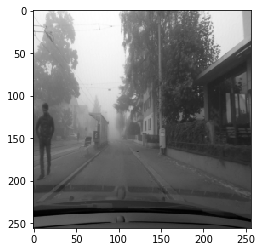

In [27]:
gray = rgb2gray(b['A'][0])
plt.imshow(gray, cmap='gray')

In [25]:
from skimage.color import rgb2gray

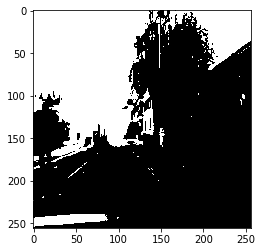

In [29]:
def mask(gray):
    gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
    for i in range(gray_r.shape[0]):
        if gray_r[i] > gray_r.mean():
            gray_r[i] = 1
        else:
            gray_r[i] = 0
    gray = gray_r.reshape(gray.shape[0],gray.shape[1])
    return gray
plt.imshow(mask(gray), cmap='gray')

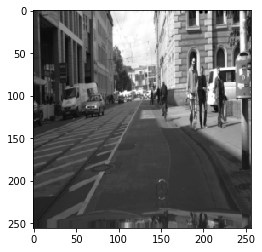

In [33]:
gray2=rgb2gray(b['B'][0])
plt.imshow(gray2,cmap="gray")

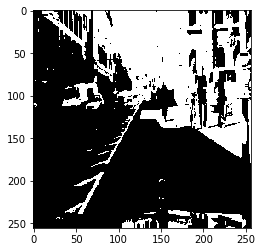

In [34]:
plt.imshow(mask(gray2),cmap="gray")

In [31]:
!nvidia-smi

Tue Dec 24 21:11:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P6            On   | 00000000:17:00.0 Off |                    0 |
| N/A   39C    P0    82W /  90W |  14231MiB / 15261MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P6            On   | 00000000:45:00.0 Off |                    0 |
| N/A   38C    P0    66W /  90W |  14422MiB / 15261MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T